# Import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pack_padded_sequence, pack_sequence, pad_packed_sequence, pad_sequence

import os
import sys
import pickle
import logging
import random
from pathlib import Path
from math import log, ceil
from typing import List, Tuple, Set, Dict

import numpy as np
import pandas as pd
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import os
import time

sys.path.append('..')
from src.data import prepare_data, prepare_seq2seq_data, SOURCE_ASSIST0910_SELF, SOURCE_ASSIST0910_ORIG
from src.utils import sAsMinutes, timeSince

sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set1')

# =========================
# PyTorch version & GPU setup
# =========================
print('PyTorch:', torch.__version__)
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# dev = torch.device('cpu')
print('Using Device:', dev)

PyTorch: 1.0.1.post2
Using Device: cuda


In [8]:
dirname = Path().resolve()
dirname

PosixPath('/home/qqhann/qqhann-paper/ECML2019/dkt_neo/notebook')

In [2]:
# =========================
# Seed
# =========================
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# =========================
# Parameters
# =========================
# model_name = 'RNN'
sequence_size = 20
epoch_size = 500
lr = 0.1
batch_size, n_hidden, n_skills, n_layers = 100, 200, 124, 1
n_output = n_skills
PRESERVED_TOKENS = 2  # PAD, SOS
onehot_size = n_skills * 2 + PRESERVED_TOKENS
n_input = ceil(log(2 * n_skills))
# n_input = onehot_size  #

NUM_EMBEDDIGNS, ENC_EMB_DIM, ENC_DROPOUT = onehot_size, n_input, 0.6
OUTPUT_DIM, DEC_EMB_DIM, DEC_DROPOUT = onehot_size, n_input, 0.6
# OUTPUT_DIM = n_output = 124  # TODO: ほんとはこれやりたい
HID_DIM, N_LAYERS = n_hidden, n_layers

# =========================
# Data
# =========================
train_dl, eval_dl = prepare_seq2seq_data(
    SOURCE_ASSIST0910_ORIG, n_skills, PRESERVED_TOKENS, min_n=3, max_n=sequence_size, batch_size=batch_size, device=dev, sliding_window=1)

# 違いを調整する <- ???
#OUTPUT_DIM = eval_dl.dataset.tensors[1].shape

torch.Size([1519, 20])
torch.Size([386, 20])


The model has 386,050 trainable parameters
Using Device: cuda


INFO:dkt log:TRAIN Epoch: 110 Loss: 0.6026374141375224
INFO:dkt log:EVAL  Epoch: 110 Loss: 0.5924338102340698
INFO:dkt log:EVAL  Epoch: 110 AUC: 0.7279595830867963
INFO:dkt log:4m 13s ( - 14m 57s) (110 22.0)
INFO:dkt log:TRAIN Epoch: 120 Loss: 0.5955672979354858
INFO:dkt log:EVAL  Epoch: 120 Loss: 0.5889008045196533
INFO:dkt log:EVAL  Epoch: 120 AUC: 0.7289609030085111
INFO:dkt log:8m 5s ( - 25m 37s) (120 24.0)
INFO:dkt log:TRAIN Epoch: 130 Loss: 0.5934534351030986
INFO:dkt log:EVAL  Epoch: 130 Loss: 0.586461583773295
INFO:dkt log:EVAL  Epoch: 130 AUC: 0.7285967866733422
INFO:dkt log:12m 10s ( - 34m 40s) (130 26.0)
INFO:dkt log:TRAIN Epoch: 140 Loss: 0.5886378367741902
INFO:dkt log:EVAL  Epoch: 140 Loss: 0.5849830309549967
INFO:dkt log:EVAL  Epoch: 140 AUC: 0.7282781848800692
INFO:dkt log:16m 12s ( - 41m 39s) (140 28.000000000000004)
INFO:dkt log:TRAIN Epoch: 150 Loss: 0.588614288965861
INFO:dkt log:EVAL  Epoch: 150 Loss: 0.5844002962112427
INFO:dkt log:EVAL  Epoch: 150 AUC: 0.72859678

40 40 40


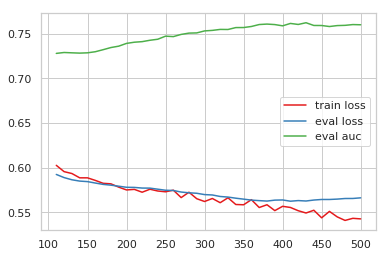

In [12]:
# =========================
# Model
# =========================
class Encoder(nn.Module):
    def __init__(self, num_embeddings, emb_dim, hid_dim, n_layers, dropout):
        # def __init__(self, dev, model_name, n_input, n_hidden, n_output, n_layers, batch_size, dropout=0.6, bidirectional=False):
        super().__init__()
        
        self.num_embeddings = num_embeddings
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(num_embeddings, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input):
        #src = [src sent len, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [src sent len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell
    
    
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        # def __init__(self, dev, model_name, n_input, n_hidden, n_output, n_layers, batch_size, dropout=0.6, bidirectional=False):
        super().__init__()
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(output_dim, emb_dim)  # 250->6
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)  # 6, 100, 1
        
        self.out = nn.Linear(hid_dim, output_dim)  # 100, 250
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        #print(input.shape) #torch.Size([21])
        input = input.unsqueeze(0)
        #print(input.shape) #torch.Size([1, 21]) 
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        #embedded = self.dropout(input)
        #print(embedded.shape)  # torch.Size([1, 15, 6])
        #embedded = [1, batch size, emb dim]
         
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #sent len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

    
OUTP = None
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, dev):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = dev
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
    
    def forward(self, src, trg, actual_q=None, teacher_forcing_ratio=0.5):
        #src = [src sent len, batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
#         print(f'target shape: {trg.shape}')
#         print(f'batch_size: {batch_size}, max_len: {max_len}')
        trg_vocab_size = self.decoder.output_dim
#         print(f'vocab size: {trg_vocab_size}')
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)  # TODO: fix hard coding
        outputs_prob = torch.zeros(max_len, batch_size, 124).to(self.device)  # TODO: fix hard coding
#         print('s2s outputs shape:', outputs.shape)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        # #first input to the decoder is the <sos> tokens
        # input = trg[0,:]
        # 
        # # print(actual_q.shape) # 100, 20, 124
        # for t in range(1, max_len):
        #     
        #     output, hidden, cell = self.decoder(input, hidden, cell)
        #     # print(output.shape) # 100, 250
        #     # つまり100ごとにバッチ処理をしていて、20のSeqを頭から順に処理している段階
        #     #global OUTP
        #     #OUTP = output
        #     outputs[t] = output
        #     o_wro = torch.sigmoid(output[:, 2:2+124])
        #     o_cor = torch.sigmoid(output[:, 2+124:])
        #     outputs_prob[t] = o_cor / (o_cor + o_wro)
        #     teacher_force = random.random() < teacher_forcing_ratio
        #     top1 = output.max(1)[1]
        #     flag = torch.zeros(100, 2)  # PRESERVED_TAGS = 2
        #     flag = torch.cat((flag, actual_q[:,t], actual_q[:,t]), dim=1)
        #     top1 = torch.max(torch.sigmoid(output) * flag, dim=1)[1]
        #     input = (trg[t] if teacher_force else top1)
        # print(actual_q.shape) # 100, 20, 124
            
        input = trg[-2,:]
         
        output, hidden, cell = self.decoder(input, hidden, cell)
        # print(output.shape) # 100, 250
        # つまり100ごとにバッチ処理をしていて、20のSeqを頭から順に処理している段階
        #global OUTP
        #OUTP = output
        outputs = output.unsqueeze(0)
        o_wro = torch.sigmoid(output[:, 2:2+124])
        o_cor = torch.sigmoid(output[:, 2+124:])
        outputs_prob = (o_cor / (o_cor + o_wro)).unsqueeze(0)
        
        return outputs, outputs_prob
    
    

# =========================
# Prepare and Train
# =========================
enc = Encoder(NUM_EMBEDDIGNS, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(dev)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).to(dev)

model = Seq2Seq(enc, dec, dev).to(dev)

# Load model
# ----------
load_model = None
epoch_start = 1

load_model = '/home/qqhann/qqhann-paper/ECML2019/dkt_neo/models/s2s_2019_0404_2021.100'
if load_model:
    epoch_start = int(load_model.split('.')[-1]) + 1
    model.load_state_dict(torch.load(load_model))
    model = model.to(dev)
# ----------


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


loss_func = nn.BCELoss()
opt = optim.SGD(model.parameters(), lr=lr)


def train():
    pass

def evaluate():
    pass

PRED = None
def main():
    debug = False 
    logging.basicConfig()
    logger = logging.getLogger('dkt log')
    logger.setLevel(logging.INFO)
    train_loss_list = []
    train_auc_list = []
    eval_loss_list = []
    eval_auc_list = []
    eval_recall_list = []
    eval_f1_list = []
    x = []
    start_time = time.time()
    for epoch in range(epoch_start, epoch_size + 1):
        print_train = epoch % 10 == 0
        print_eval = epoch % 10 == 0
        print_auc = epoch % 10 == 0

        
        # =====
        # TRAIN
        # =====
        model.train()

        val_pred = []
        val_actual = []
        current_epoch_train_loss = []
        for xs, ys, yq, ya, yp in train_dl:
            input = xs
            target = ys
            input = input.permute(1, 0)
            target = target.permute(1, 0)

            out, out_prob = model(input, target, yq)
            out = out.permute(1, 0, 2)
            out_prob = out_prob.permute(1, 0, 2)

            pred = torch.sigmoid(out)  # [0, 1]区間にする
            # _, pred = torch.max(pred, 2)
            target = torch.tensor([list(torch.eye(NUM_EMBEDDIGNS)[i]) for i in target.contiguous().view(-1)])\
                .contiguous().view(batch_size, -1, NUM_EMBEDDIGNS).to(dev)
            
            # --- 指標評価用データ
#             print(out_prob.shape, yq[:,-1,:].unsqueeze(1).shape)
            prob = torch.max(out_prob * yq[:,-1,:].unsqueeze(1), 2)[0]
            val_pred.append(prob)
            val_actual.append(ya[:,-1])
            # ---
            
#             print(prob.shape, ya.shape)
            loss = loss_func(prob[:,-1], ya[:,-1]) 
            
            current_epoch_train_loss.append(loss.item())
            

            # バックプロバゲーション
            opt.zero_grad()
            loss.backward()
            opt.step()

            # stop at first batch if debug
            if debug:
                break
                
        if print_train:
            loss = np.array(current_epoch_train_loss)
            logger.log(logging.INFO + (5 if epoch % 100 == 0 else 0),
                       'TRAIN Epoch: {} Loss: {}'.format(epoch, loss.mean()))
            train_loss_list.append(loss.mean())
            
            # # AUC, Recall, F1
            # # TRAINの場合、勾配があるから処理が必要
            # y = torch.cat(val_targ).cpu().detach().numpy()
            # pred = torch.cat(val_prob).cpu().detach().numpy()
            # # AUC
            # fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
            # logger.log(logging.INFO + (5 if epoch % 100 == 0 else 0), 
            #            'TRAIN Epoch: {} AUC: {}'.format(epoch, metrics.auc(fpr, tpr)))
            # train_auc_list.append(metrics.auc(fpr, tpr))


        # =====
        # EVAL
        # =====
        if print_eval:
            with torch.no_grad():
                model.eval()

                val_pred = []
                val_actual = []
                current_eval_loss = []
                for xs, ys, yq, ya, yp in eval_dl:
                    input = xs
                    target = ys
                    input = input.permute(1, 0)
                    target = target.permute(1, 0)

                    out, out_prob = model(input, target, yq)
                    out = out.permute(1, 0, 2)
                    out_prob = out_prob.permute(1, 0, 2)

                    pred = torch.sigmoid(out)  # [0, 1]区間にする
                    # _, pred = torch.max(pred, 2)
                    target = torch.tensor([list(torch.eye(NUM_EMBEDDIGNS)[i]) for i in target.contiguous().view(-1)])\
                        .contiguous().view(batch_size, -1, NUM_EMBEDDIGNS).to(dev)

                    # --- 指標評価用データ
                    prob = torch.max(out_prob * yq[:,-1,:].unsqueeze(1), 2)[0]
                    val_pred.append(prob)
                    val_actual.append(ya[:,-1])
                    # ---

        #             print(prob.shape, ya.shape)
                    loss = loss_func(prob[:,-1], ya[:,-1]) 
    
                    current_eval_loss.append(loss.item())

                    # stop at first batch if debug
                    if debug:
                        break
                        
                loss = np.array(current_eval_loss)
                logger.log(logging.INFO + (5 if epoch % 100 == 0 else 0), 
                           'EVAL  Epoch: {} Loss: {}'.format(epoch,  loss.mean()))
                eval_loss_list.append(loss.mean())

                # AUC, Recall, F1
                if print_auc:
                    y = torch.cat(val_actual).view(-1).cpu()  # TODO: viewしない？　最後の1個で？
                    pred = torch.cat(val_pred).view(-1).cpu()
                    # AUC
                    fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
                    logger.log(logging.INFO + (5 if epoch % 100 == 0 else 0), 
                               'EVAL  Epoch: {} AUC: {}'.format(epoch, metrics.auc(fpr, tpr)))
                    eval_auc_list.append(metrics.auc(fpr, tpr))
                #     # Recall
                #     logger.debug('EVAL  Epoch: {} Recall: {}'.format(epoch, metrics.recall_score(y, pred.round())))
                #     # F1 score
                #     logger.debug('EVAL  Epoch: {} F1 score: {}'.format(epoch, metrics.f1_score(y, pred.round())))
        
        if epoch % 10 == 0:
            x.append(epoch)
            logger.info(f'{timeSince(start_time, epoch / epoch_size)} ({epoch} {epoch / epoch_size * 100})')

        
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x, train_loss_list, label='train loss')
    # ax.plot(x, train_auc_list, label='train auc')
    ax.plot(x, eval_loss_list, label='eval loss')
    ax.plot(x, eval_auc_list, label='eval auc')
    ax.legend()
    print(len(train_loss_list), len(eval_loss_list), len(eval_auc_list))
    plt.show()


if __name__ == '__main__':
    print('Using Device:', dev)
    main()

In [48]:
model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(250, 6)
    (rnn): LSTM(6, 200, dropout=0.6)
    (dropout): Dropout(p=0.6)
  )
  (decoder): Decoder(
    (embedding): Embedding(250, 6)
    (rnn): LSTM(6, 200, dropout=0.6)
    (out): Linear(in_features=200, out_features=250, bias=True)
    (dropout): Dropout(p=0.6)
  )
)

In [55]:
import datetime
now = datetime.datetime.now().strftime('%Y_%m%d_%H%M')

torch.save(model.state_dict(), '/home/qqhann/qqhann-paper/ECML2019/dkt_neo/models/s2s_' + now + '.' + str(epoch))